# Задания<a class="anchor" style="autocontent" id="Задания"/><br>

In [20]:
!pip install gdown
!pip install catboost
!pip install pytorch-tabnet
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [22]:
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, average_precision_score
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

from sklearn.metrics import matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import pandas as pd
import numpy as np 
import scipy


import xgboost
import lightgbm
import catboost
from pytorch_tabnet.tab_model import  TabNetRegressor


# task 7
import imblearn

## Задание 1<a class="anchor" style="autocontent" id="Задание-1"/><br>

Продемонстрируйте bias-variance trade-off на примере DecisionTreeRegressor на представленном датасете, используя функцию plot_regression_predictions (можете модифицировать)

In [3]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1) * 3 - 1
y = 4 * (X - 0.5) ** 3
y = (y + np.random.randn(m, 1) / 10)

In [4]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -1, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
    
    


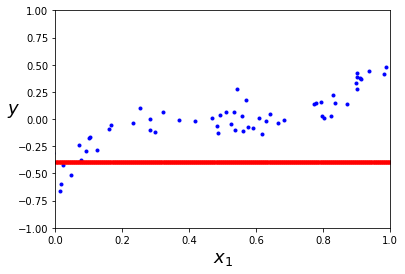

In [5]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, y, random_state=777)
#print(Y_train1)
clf1 = DecisionTreeRegressor(max_depth = 3)
clf1.fit(X_train1, Y_train1)
plot_regression_predictions(clf1, X, y)

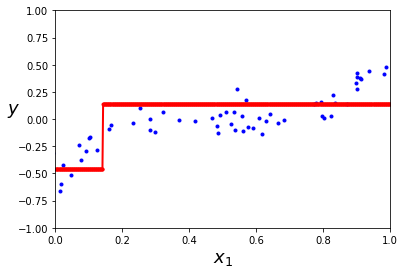

In [6]:
clf2 = DecisionTreeRegressor(max_depth = 5)
clf2.fit(X_train1, Y_train1)
plot_regression_predictions(clf2, X, y)
#С глубиной деревьев 3 и 5 модели явно недоучены

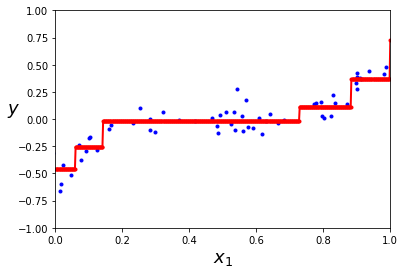

In [7]:
clf4 = DecisionTreeRegressor(max_depth = 7)
clf4.fit(X_train1, Y_train1)
plot_regression_predictions(clf4, X, y) # выглядит оптимально

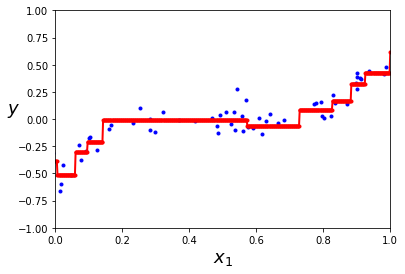

In [8]:
clf5 = DecisionTreeRegressor(max_depth = 8)
clf5.fit(X_train1, Y_train1)
plot_regression_predictions(clf5, X, y)
# При глубине дерева 8 модель начинает уже переобучаться, это видно по краям графика

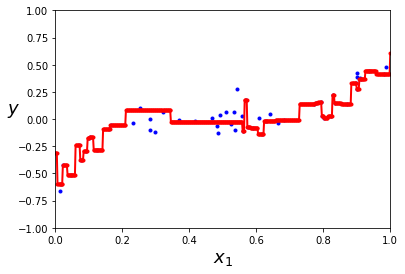

In [9]:
clf3 = DecisionTreeRegressor(max_depth = 12)
clf3.fit(X_train1, Y_train1)
plot_regression_predictions(clf3, X, y)# совсем переобучена

## Задание 2<a class="anchor" style="autocontent" id="Задание-2"/><br>

На выданном датасете breast_cancer обучите модели Decision Tree, Random Forest, LigthGBMClassifier, SVC с базовым класификатором - SVC . Параметры моделей можете оставить по-умолчанию или задать сами


Для каждой модели посчитайте корреляцию мэтьюса (**sklearn.metrics.matthews_corrcoef**, почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) предсказанного ею класса и реального 

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей.

Постройте боксплоты для качества полученных моделей

Используйте функцию bootstrap metric из лекции.

In [10]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [11]:
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

In [12]:
def bootstrap_metric(x, 
                     y,
                    metric_fn,
                    samples_cnt=1000,
                    alpha=0.05,
                    random_state=777):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    
    return b_metric

In [13]:
#Обучаем модели по порядку: SVC, Decision Tree, Random Forest и  LightGBMClassifier
models ={}
models['svc'] = GridSearchCV(SVC(), {'kernel':('linear', 
                                           'rbf'),
                                 'C':[0.01, 0.1, 1, 10]}
                         ).fit(X_train, y_train)

models["dt"] = GridSearchCV(DecisionTreeClassifier(), 
                          {'max_depth':[1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10]}
                     ).fit(X_train, y_train)

models["rt"] =  GridSearchCV(RandomForestClassifier(), 
                          {'max_depth':[1, 3, 5, 7, 10],
                           'min_samples_leaf': [1, 3, 5, 10]} 
                     ).fit(X_train, y_train)
models['lightgbm'] = GridSearchCV(lightgbm.LGBMClassifier(), {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}).fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred1 = models['svc'].decision_function(X_test)
y_pred2 = models['dt'].predict_proba(X_test)[:, 1]
y_pred3 = models['rt'].predict_proba(X_test)[:, 1]
y_pred4 = models['lightgbm'].predict_proba(X_test)[:, 1]
#отдельно точности, чтобы проверить, что они считаются
qual1 = average_precision_score(y_true=y_test, y_score=y_pred1)
qual2 = average_precision_score(y_true=y_test, y_score=y_pred2)
qual3 = average_precision_score(y_true=y_test, y_score=y_pred3)
qual4 = average_precision_score(y_true=y_test, y_score=y_pred4)
print(qual1, qual2, qual3, qual4)

boot_score_svc = bootstrap_metric(y_test, 
                                   y_pred1, 
                                   metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y))
boot_score_dt = bootstrap_metric(y_test,
                                   y_pred2,
                                   metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y))
boot_score_rt = bootstrap_metric(y_test,
                                   y_pred3,
                                   metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y))
boot_score_lightgbm = bootstrap_metric(y_test,
                                   y_pred4,
                                   metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y))
plt.figure(figsize=(10,10))
sns.boxplot(y=np.concatenate([boot_score_svc, 
                              boot_score_dt,
                              boot_score_rt,
                              boot_score_lightgbm]),
             x=["SVC"] * 1000 + ['DT'] * 1000 + ['RF'] * 1000 + ['lightgbm'] * 1000)
plt.show()

#на графиках видно, что Дерево Решений уступает остальным моделям по доверительному интервалу, это же видно и по средней точности.

In [ ]:
mtskoeff1 = sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred1.round())
mtskoeff2 = sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred2.round())
mtskoeff3 = sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred3.round())
mtskoeff4 = sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred4.round()) #без округления выдавало ошибку, решение найдено на
# https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
# однако, там есть комментарий, что такая ошибка может говорить о неверном теоретическом подходе
print(mtskoeff1, mtskoeff2, mtskoeff3, mtskoeff4)

## Задание 3<a class="anchor" style="autocontent" id="Задание-4"/><br>


Загрузим датасет с рецептами (состав блюд и дополнительные данные о них) и рейтинге рецептов. Попробуем по всем признакам предсказывать рейтинг рецепта.



In [14]:
!gdown --id 1gr1WaAFZphKQxzUFIxAYqiTqRJsC-mFK -O recipes.csv

Downloading...
From: https://drive.google.com/uc?id=1gr1WaAFZphKQxzUFIxAYqiTqRJsC-mFK
To: /content/recipes.csv
55.3MB [00:00, 175MB/s]


In [15]:
t = pd.read_csv("recipes.csv")
print(t.iloc[:, 0:5].head())

                                         title  rating  calories  protein   fat
0              Lentil, Apple, and Turkey Wrap    2.500     426.0     30.0   7.0
1  Boudin Blanc Terrine with Red Onion Confit    4.375     403.0     18.0  23.0
2                Potato and Fennel Soup Hodge    3.750     165.0      6.0   7.0
3             Mahi-Mahi in Tomato Olive Sauce    5.000       NaN      NaN   NaN
4                    Spinach Noodle Casserole    3.125     547.0     20.0  32.0


In [16]:
t = t.loc[pd.isna(t).sum(axis=1)==0, :] # remove na
y = t['rating']
X = t.drop(["rating", "title"], axis=1)
X_train_all, X_test, y_train_all, y_test = train_test_split(X.values, y.values, train_size=0.7, random_state=1999)

Выберите 2 модели - один случайный лес и один бустинг из приведенных ниже.

1. xgboost.XGBRegressor
2. xgboost.XGBRFRegressor (случайный лес от xgboost)
3. lightgbm.LGBMRegressor
4. lightgbm.LGBMRegressor с boosting_type="rf" (случайный лес от lightgbm)
5. catboost.CatBoostRegressor

Кроме этого, используйте так же 
TabNetRegressor

Для первых двух моделей попытайтесь оптимизировать их параметры, чтобы получить хорошее качество 
Для TabNetRegressor попробуйте разные значения параметров **n_a** и **n_d**. Поставьте число эпох (max_epochs, параметр функции fit) равным 30 (можете при желании подбирать и этот параметр)

Сравните качество полученных моделей 

In [17]:
from sklearn.metrics import mean_squared_error
def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                       y_pred, 
                                       metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                      y_pred=y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    # cast to long format
    results = results.melt(value_vars=results.columns,
                       value_name="mse", 
                       var_name="model") 
    return results

In [ ]:
models_3 = {}
models_3['xgb'] = GridSearchCV(xgboost.XGBRegressor(),{'n_estimators':[50, 150, 250, 500], 
                                               'max_depth':[5, 10, 15, 20],
                                                'reg_lambda':[0.001, 0.01, 0.1]}).fit(X_train_all, y_train_all)
models_3['xgrf'] = GridSearchCV(xgboost.XGBRFRegressor(),{'n_estimators':[50, 150, 250, 500], 
                                               'max_depth':[5, 10, 15, 20],
                                                'reg_lambda':[0.001, 0.01, 0.1]}).fit(X_train_all, y_train_all)
results_rf = train_and_test_regressor(models_3, X_train_all, y_train_all, X_test, y_test)

[12:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:55:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=results_rf , y="mse", x="model")
plt.show()

In [70]:
models_3['TabNet'] = TabNetRegressor() 
for epoch in range(30):
  models_3['TabNet'].fit( X_train_all, y_train_all, eval_set=[(X_test, y_test)])
  y_pred = models_3['TabNet'].predict(X_test)
  qual = average_precision_score(y_true=y_test, y_score=y_pred)
  if best_qual < qual:
     best_qual = qual
  print(f"Epoch {epoch}, average precision score:{qual}")
print(f"Best average precision score is {best_quay}")


Device used : cuda


ValueError: ignored